In [2]:
import numpy as np
import cupy as cp
import matplotlib.pylab as plt
import scipy.io

from operations import *
from plots import *

In [3]:
# Load data
mat_file = scipy.io.loadmat("../data/data.mat")
data = cp.array(mat_file["stack"])

# 480, 480, 9
sizeX, sizeY, sizeZ = data.shape

# shape = (1, 1, 9, 3)
depthCode = cp.array(mat_file["depthCode"])

In [4]:
# Imaging parameters
NA = 0.4            # objective numerical aperture
dz = 20.56          # delta z (um)
dx = 1.083          # lateral pixel size (um)
wavelength = 0.51   # um
n = 1.0             # refractive index

# Optimization parameters
TV_reg = 0          # amount of TV regularization
xy_pad = 50         # lateral volume extension
z_pad = 8           # axial volume extension
outer_iter = 20    # outer iterations of EV-3D algorithm
inner_iter = 80    # inner iterations of EV-3D algorithm

In [5]:
### EV-3D deconvolution ###
# deconv shape: 580, 580, 25
Nx = sizeX + 2 * xy_pad
Nz = sizeZ + 2 * z_pad

# Point spread function (PSF)
psf = ComputeGaussianPSF(NA, wavelength, dx, dz, (Nx, Nx, int(Nz / 2)), n)

# Optical transfer function (OTF)
# otf = pypher.tests.test_pypher.psf2otf(psf, [Nx, Nx, Nz])
otf = GenerateOTF(psf, [Nx, Nx, Nz])

In [6]:
otf_import = scipy.io.loadmat("../data/otf.mat")
otf_import = cp.array(otf_import['otf'])
print(cp.sum((otf - otf_import) ** 2))      # if not close to 0, there is some problem in GenerateOTF()

(2.0902330534259884e-22+2.115740304229619e-28j)


In [7]:
image_ev = cp.pad(data, ((xy_pad, xy_pad), (xy_pad, xy_pad), (z_pad, z_pad)), mode='edge')

image_mask = cp.pad(data, ((xy_pad, xy_pad), (xy_pad, xy_pad), (z_pad, z_pad)), mode='constant', constant_values=0)
image_mask = cp.where(image_mask > 0)
obs = data[data > 0]

In [8]:
est = 0
for i in range(0, outer_iter):
    print("[Outer Iteration] #", str(i+1), sep='')
    est = RL_TV(image_ev, otf, inner_iter, TV_reg)
    image_ev = (cp.fft.ifftn(cp.fft.fftn(est) * otf)).real
    image_ev = cp.maximum(image_ev, 0)
    image_ev[image_mask] = obs

EV = est[(xy_pad):(xy_pad+sizeX), (xy_pad):(xy_pad+sizeY), (z_pad):(z_pad+
                                                                          sizeZ)]

[Outer Iteration] #1
[Inner Iteration] #1
[Inner Iteration] #2
[Inner Iteration] #3
[Inner Iteration] #4
[Inner Iteration] #5
[Inner Iteration] #6
[Inner Iteration] #7
[Inner Iteration] #8
[Inner Iteration] #9
[Inner Iteration] #10
[Inner Iteration] #11
[Inner Iteration] #12
[Inner Iteration] #13
[Inner Iteration] #14
[Inner Iteration] #15
[Inner Iteration] #16
[Inner Iteration] #17
[Inner Iteration] #18
[Inner Iteration] #19
[Inner Iteration] #20
[Inner Iteration] #21
[Inner Iteration] #22
[Inner Iteration] #23
[Inner Iteration] #24
[Inner Iteration] #25
[Inner Iteration] #26
[Inner Iteration] #27
[Inner Iteration] #28
[Inner Iteration] #29
[Inner Iteration] #30
[Inner Iteration] #31
[Inner Iteration] #32
[Inner Iteration] #33
[Inner Iteration] #34
[Inner Iteration] #35
[Inner Iteration] #36
[Inner Iteration] #37
[Inner Iteration] #38
[Inner Iteration] #39
[Inner Iteration] #40
[Inner Iteration] #41
[Inner Iteration] #42
[Inner Iteration] #43
[Inner Iteration] #44
[Inner Iteration] #4

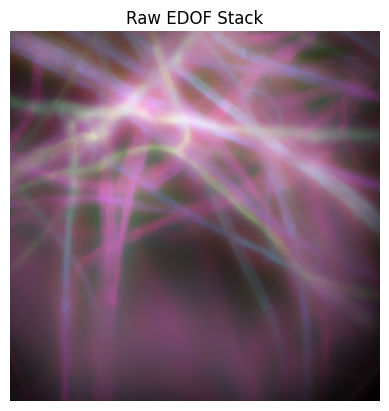

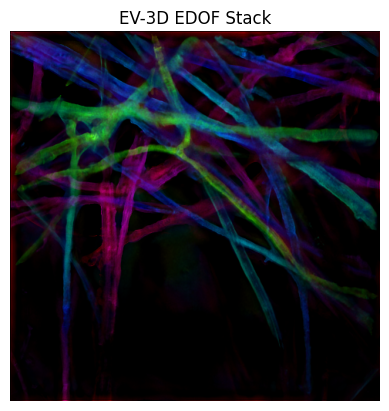

In [9]:
plotResults(data, EV, depthCode)

In [13]:
np.save('../output/EV', EV)
np.save('../output/depthCode', depthCode)

In [26]:
EV_load = np.load('../output/EV.npy')
depthCode_load = np.load('../output/depthCode.npy')

print((EV_load[..., np.newaxis] * depthCode_load).shape)

edof = np.squeeze(np.sum(EV_load[..., np.newaxis] * depthCode_load, axis=2))
edof = edof - np.min(edof)
edof = edof / np.max(edof)

H, W, C = edof.shape

for h in range(0, H):
    for w in range(0, W):
        print(edof[h, w, :])
    print(' ')

(480, 480, 9, 3)
[0. 0. 0.]
[0.08803888 0.         0.01486456]
[0.04311523 0.00121526 0.01446433]
[0.04282498 0.0046635  0.0212385 ]
[0.032469   0.00677382 0.02749355]
[0.02586633 0.00125186 0.02520923]
[0.02052906 0.         0.02084971]
[0.01774098 0.         0.01368026]
[0.02170315 0.         0.01622445]
[0.0272826  0.         0.02029719]
[0.02554418 0.         0.01914834]
[0.01758497 0.         0.01334227]
[0.01131811 0.         0.00861031]
[0.0095911  0.         0.00698504]
[0.00890855 0.         0.00615445]
[0.01014848 0.         0.00692484]
[0.01010595 0.         0.00689583]
[0.00918412 0.         0.00626681]
[0.00710956 0.         0.00485123]
[0.00551192 0.         0.00376107]
[0.00384322 0.         0.00262243]
[0.00339178 0.         0.00231439]
[0.00203778 0.         0.00149006]
[0.00153369 0.         0.00232793]
[0.00143376 0.         0.00217624]
[0.0002416  0.         0.00036672]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.

KeyboardInterrupt: 